In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# 1.0 Install Mask RCNN library

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/HD_object_recognition/Mask_RCNN
!python setup.py install

/content/drive/My Drive/Colab Notebooks/HD_object_recognition/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn


# 1.1 Install compatible version of tensorflow

In [ ]:
# ## define target folder to clone repository
# %cd /content/drive/My Drive/Colab Notebooks/ObjectRecognition

# !pip install tensorflow==1.14  ##==1.15.2
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

TensorFlow 1.x selected.
1.15.2


# 2.0 Join validation image tiles into single HD image
Creates a HD image from tiles not in the training dataset.  For testing purposes.

In [ ]:
import os
import cv2
import random


def concat_tile(im_list_2d):
    """ joins nested lists of image tiles into a single image """
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])


PATH = '/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/validation images'

# create folder to receive files
os.chdir(PATH)
if not os.path.exists('concatenated'):
    os.mkdir('concatenated')

# load image tiles
im1 = cv2.imread(str(PATH)+'/00031.JPG')
im2 = cv2.imread(str(PATH)+'/00032.JPG')
im3 = cv2.imread(str(PATH)+'/00033.JPG')
im4 = cv2.imread(str(PATH)+'/00034.JPG')
im5 = cv2.imread(str(PATH)+'/00035.JPG')
im6 = cv2.imread(str(PATH)+'/00036.JPG')

# join tiles into single image
im = concat_tile([[im1, im2, im3],
                  [im4, im5, im6]])

# save file with random filename
letters = 'qwertyuiopasdfghjklzxcvbnm'
name = ''.join(random.choice(letters) for i in range(6))
cv2.imwrite(str(PATH) +'/concatenated/'+ str(name) +'.JPG', im)
print(name +'.JPG')


# 3.0 Split HD images into tiles


In [ ]:
import os
import cv2
import math

TILE_SIZE = (2240, 2240)   # (x,y)
OFFSET = (2240, 2240)      # (x,y)
PATH = '/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images'

# create folder to receive output
os.chdir(PATH)
if not os.path.exists('tiled output'):
    os.mkdir('tiled output')

# iterate through image(s) in source folder
for filename in os.listdir(PATH):
    if not filename.endswith('.JPG'): continue

    # check resolution
    img = cv2.imread(str(PATH)+'/'+str(filename))   # 6720, 4480
    img_shape = img.shape                           # 4480, 6720 (y,x)!

    # split each photo into six (3x2) tiles
    for j in range(int(math.ceil(img_shape[0] / OFFSET[1]))):
        for i in range(int(math.ceil(img_shape[1] / OFFSET[0]))):
            cropped_img = img[OFFSET[1] * j : min(OFFSET[1] * j + TILE_SIZE[1], img_shape[0]), \
                          OFFSET[0]*i : min(OFFSET[0] * i + TILE_SIZE[0], img_shape[1])]
            x_min = OFFSET[0] * i
            y_min = OFFSET[1] * j
            x_max = min(OFFSET[0] * i + TILE_SIZE[0], img_shape[1])
            y_max = min(OFFSET[1] * j + TILE_SIZE[1], img_shape[0])
            print('relative coordinates: (', '%4.f' % x_min, ', %4.f' % y_min, ')   filename: '  + str(filename[:-4]) + '__' + str(j) + '_' + str(i) + '.JPG')

            # save image tiles to output folder using original filename and tile reference
            cv2.imwrite(str(PATH) + '/tiled output/' + str(filename[:-4]) + '__' + str(j) + '_' + str(i) + '.JPG', cropped_img)


relative coordinates: (    0 ,    0 )   filename: hoazmu__0_0.JPG
relative coordinates: ( 2240 ,    0 )   filename: hoazmu__0_1.JPG
relative coordinates: ( 4480 ,    0 )   filename: hoazmu__0_2.JPG
relative coordinates: (    0 , 2240 )   filename: hoazmu__1_0.JPG
relative coordinates: ( 2240 , 2240 )   filename: hoazmu__1_1.JPG
relative coordinates: ( 4480 , 2240 )   filename: hoazmu__1_2.JPG
relative coordinates: (    0 ,    0 )   filename: dztbji__0_0.JPG
relative coordinates: ( 2240 ,    0 )   filename: dztbji__0_1.JPG
relative coordinates: ( 4480 ,    0 )   filename: dztbji__0_2.JPG
relative coordinates: (    0 , 2240 )   filename: dztbji__1_0.JPG
relative coordinates: ( 2240 , 2240 )   filename: dztbji__1_1.JPG
relative coordinates: ( 4480 , 2240 )   filename: dztbji__1_2.JPG
relative coordinates: (    0 ,    0 )   filename: oazujj__0_0.JPG
relative coordinates: ( 2240 ,    0 )   filename: oazujj__0_1.JPG
relative coordinates: ( 4480 ,    0 )   filename: oazujj__0_2.JPG
relative c

# 3.1 Predict objects in tiles
Creates one PascalVOC XML file per original HD image.

/content/drive/My Drive/Colab Notebooks/HD_object_recognition/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn


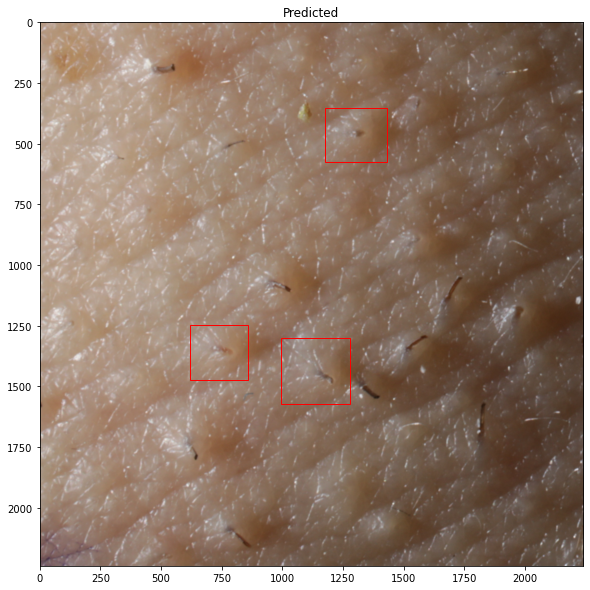

skin data/prediction images/tiled output/hoazmu__0_1.JPG


KeyboardInterrupt: ignored

In [ ]:
from os import listdir
from xml.etree import ElementTree as ET
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import time
import shutil


class SkinDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		""" load the dataset definitions """
		self.add_class("dataset", 1, "follicular_bump")
		self.add_class("dataset", 2, "pre_erupted")
		images_dir = dataset_dir + '/prediction images/tiled output/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			img_path = images_dir + filename
			self.add_image('dataset', image_id=image_id, path=img_path) #, ii=ii, jj=jj)

	def image_reference(self, image_id):
		""" returns an image reference """
		info = self.image_info[image_id]
		return info['path']


class PredictionConfig(Config):
	NAME = "predic_cfg"
	NUM_CLASSES = 3
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1


def create_xmls():
	""" creates a blank PascalVOC XML file for each HD photo in 'prediction images' folder """
	for photo_name in listdir('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images'):
		if not photo_name.endswith('.JPG'):
			continue
		tree = ET.parse('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images/template files/initial.xml')
		xml_name = photo_name[:-4]
		tree.write('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images/'+ xml_name +'.xml')


def refresh_mcrnn():
	""" reinstall MRCNN so 'tiled output' photo folder is recognised """
	%cd /content/drive/My Drive/Colab Notebooks/HD_object_recognition/Mask_RCNN
	!python setup.py install


def plot_predictions(dataset, model, cfg, n_tiles):
	""" plot a number of photos with ground truth and predictions """
	# load image tiles
	for i in range(n_tiles):
		image = dataset.load_image(i)
		img_path = dataset.image_reference(i)
		print(img_path)
		xml_name = img_path[-15:-9]
		i_tag = img_path[-5:-4]        # horizontal tile location
		j_tag = img_path[-7:-6]        # vertical tile location
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)

		# load correct xml file for each tile
		tree = ET.parse('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images/'+ xml_name +'.xml')
		root = tree.getroot()

		# make prediction
		y_predict = model.detect(sample, verbose=0)[0]

		# show image
		pyplot.figure(figsize=(30,10))
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()

		for box in y_predict['rois']:
			# display each predicted object
			y1, x1, y2, x2 = box
			class_id = y_predict['class_ids'][0]
			class_dict = {1:"follicular_bump", 2:"pre_erupted"}
			class_desc = class_dict.get(class_id)
			width, height = x2 - x1, y2 - y1
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			ax.add_patch(rect)
			print('(',x1,',',y1,') to (',x2,',',y2,')  class:', class_desc)

			# recalculate feature coordinates based on tile location in original image
			new_x1 = (x1 + 2240 * int(i_tag))
			new_y1 = (y1 + 2240 * int(j_tag))
			new_x2 = (x2 + 2240 * int(i_tag))
			new_y2 = (y2 + 2240 * int(j_tag))

			# update mathcing pascalVOC XML file with features and their bounding box coordinates
			_root=ET.SubElement(root,'object')
			_name=ET.SubElement(_root,'name')
			_name.text = str(class_desc)

			_bndbox=ET.SubElement(_root,'bndbox')
			_xmin=ET.SubElement(_bndbox,'xmin')
			_xmin.text=str(new_x1)

			_ymin=ET.SubElement(_bndbox,'ymin')
			_ymin.text=str(new_y1)

			_xmax=ET.SubElement(_bndbox,'xmax')
			_xmax.text=str(new_x2)

			_ymax=ET.SubElement(_bndbox,'ymax')
			_ymax.text=str(new_y2)

		# update XML file with all objects
		tree.write('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images/'+ xml_name +'.xml')
		pyplot.show()


# initialise data
create_xmls()
refresh_mcrnn()   # use if 'tiled output' folder is not recognised
predict_set = SkinDataset()
predict_set.load_dataset('skin data')
predict_set.prepare()
print('Predict: %d' % len(predict_set.image_ids))

# initialise model
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.keras_model.metrics_tensors = []
best_model_file = '/content/drive/My Drive/Colab Notebooks/HD_object_recognition/Mask_RCNN/models/best_so_far.h5'
model.load_weights(best_model_file, by_name=True)

# generate outputs
plot_predictions(predict_set, model, cfg, n_tiles=36)  # input total number of tiles to process

# delete folder of tiled images
shutil.rmtree('/content/drive/My Drive/Colab Notebooks/HD_object_recognition//skin data/prediction images/tiled output')
